In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and clean data.
df = pd.read_csv("marketing_campaign.csv", sep="\t")

# Had the best results from dropna, tried to full NA data with averages, but there was no improvement.
# The dataset is very clean.
df = df.dropna()



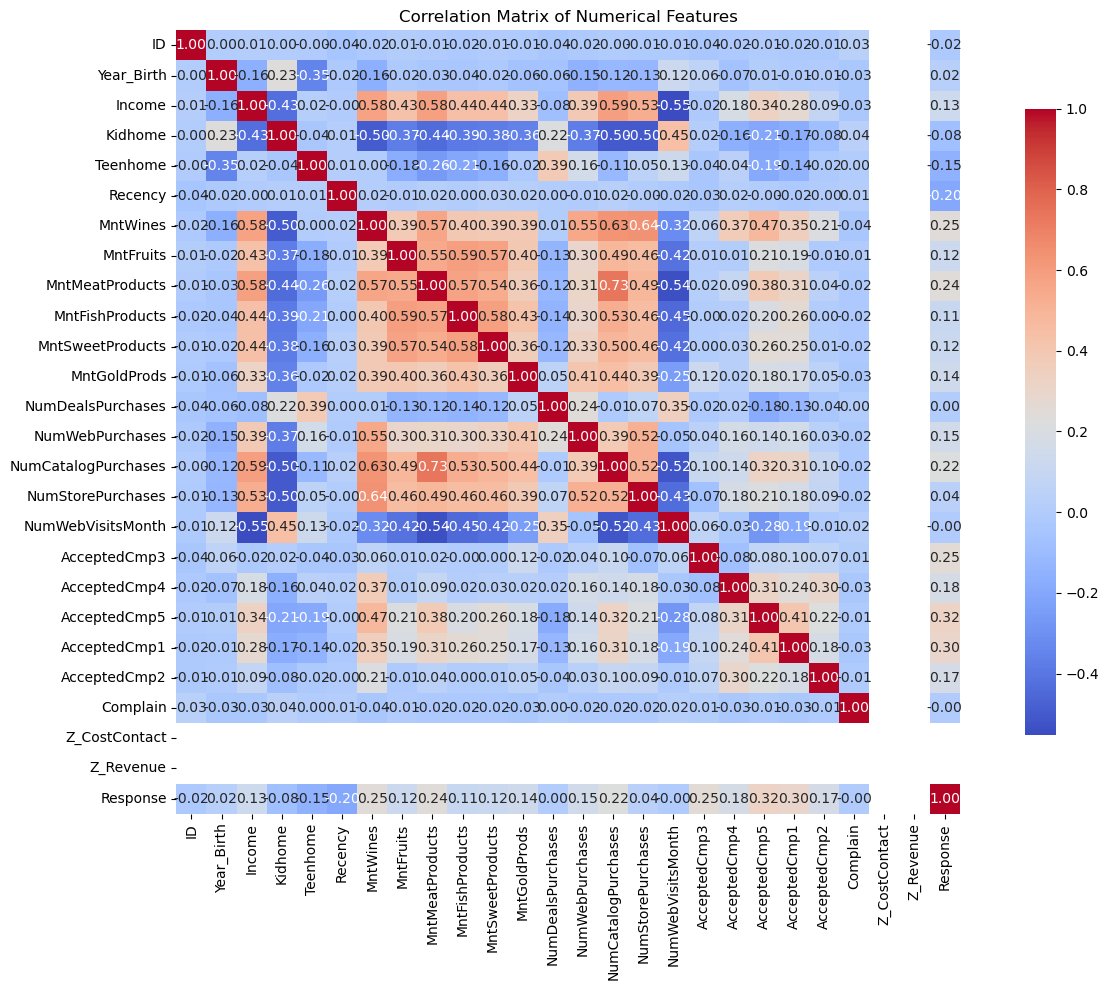

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix to see which features would be the best to select
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


In [4]:
# Target is the column we are trying to predict.
target = "MntFruits"

# Features: 9 numerical + 1 categorical.
selected_features = [
    "MntFishProducts", "MntSweetProducts", "MntMeatProducts",
    "NumCatalogPurchases", "NumStorePurchases", "Income",
    "MntGoldProds", "MntWines", "NumWebPurchases", "Education"
]

X = df[selected_features]
y = df[target]

numerical_features = [col for col in selected_features if col != "Education"]
categorical_features = ["Education"]

# Preprocessing
# Applied a standard scaler to ensure all of the numerical features were within the same scale.
# Used one hot encoding on the categorical features.

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Model pipelines.
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=50))
])

# Split data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Fit models.
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate.
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5]
}

# We optimized random forest with GridSearchCV.
rf_optimized = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1)
rf_optimized.fit(X_train, y_train)
y_pred_rf_opt = rf_optimized.predict(X_test)

results = {
    "Linear Regression": {
        "MSE": mean_squared_error(y_test, y_pred_lr),
        "MAE": mean_absolute_error(y_test, y_pred_lr),
        "R2": r2_score(y_test, y_pred_lr)
    },
    "Random Forest (Optimized)": {
        "MSE": mean_squared_error(y_test, y_pred_rf_opt),
        "MAE": mean_absolute_error(y_test, y_pred_rf_opt),
        "R2": r2_score(y_test, y_pred_rf_opt),
        "Best Params": rf_optimized.best_params_
    }
}

print("Linear Regression Results: ", results["Linear Regression"])
print("Random Forest Results: ", results["Random Forest (Optimized)"])


Linear Regression Results:  {'MSE': 721.3680943054096, 'MAE': 16.25139120624155, 'R2': 0.49549689784295003}
Random Forest Results:  {'MSE': 545.6665964527027, 'MAE': 13.096610360360362, 'R2': 0.6183772295627531, 'Best Params': {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}}


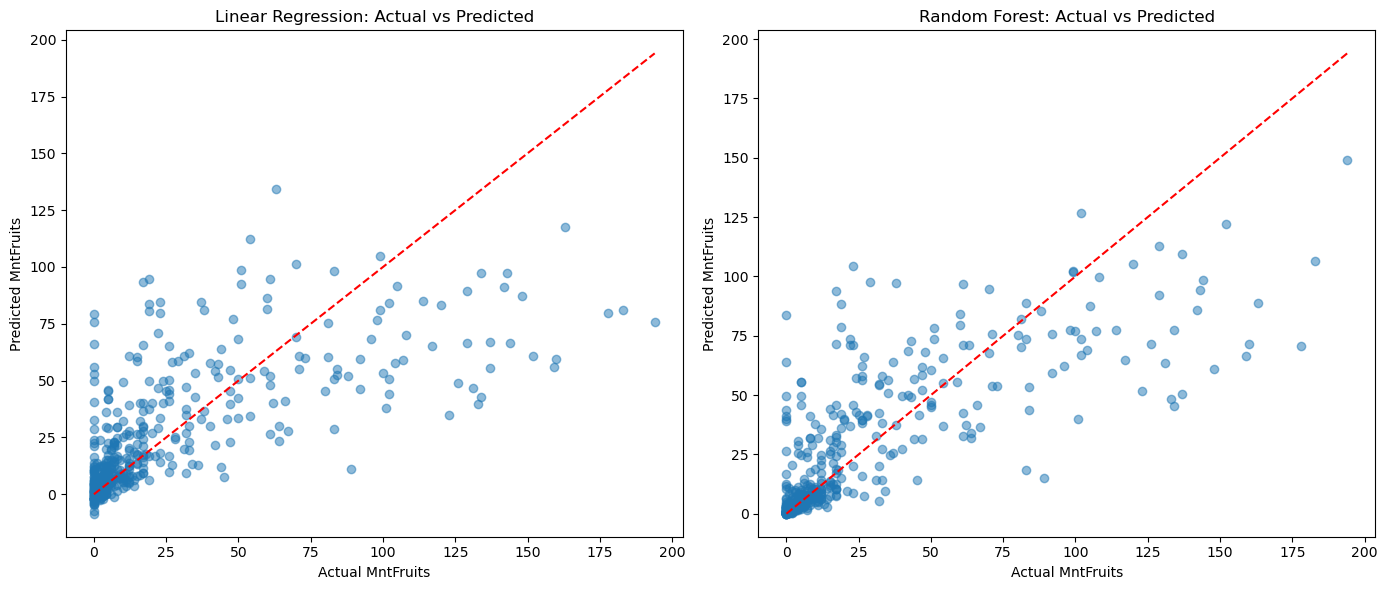

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual MntFruits")
plt.ylabel("Predicted MntFruits")
plt.title("Linear Regression: Actual vs Predicted")

# Random Forest Before optimzation (Commented out for now, may not use again)
#plt.subplot(1, 2, 2)
#plt.scatter(y_test, y_pred_rf, alpha=0.5)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
#plt.xlabel("Actual MntFruits")
#plt.ylabel("Predicted MntFruits")
#plt.title("Random Forest: Actual vs Predicted")

# Random Forest (Optimized)
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf_opt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual MntFruits")
plt.ylabel("Predicted MntFruits")
plt.title("Random Forest: Actual vs Predicted")

plt.tight_layout()
plt.show()


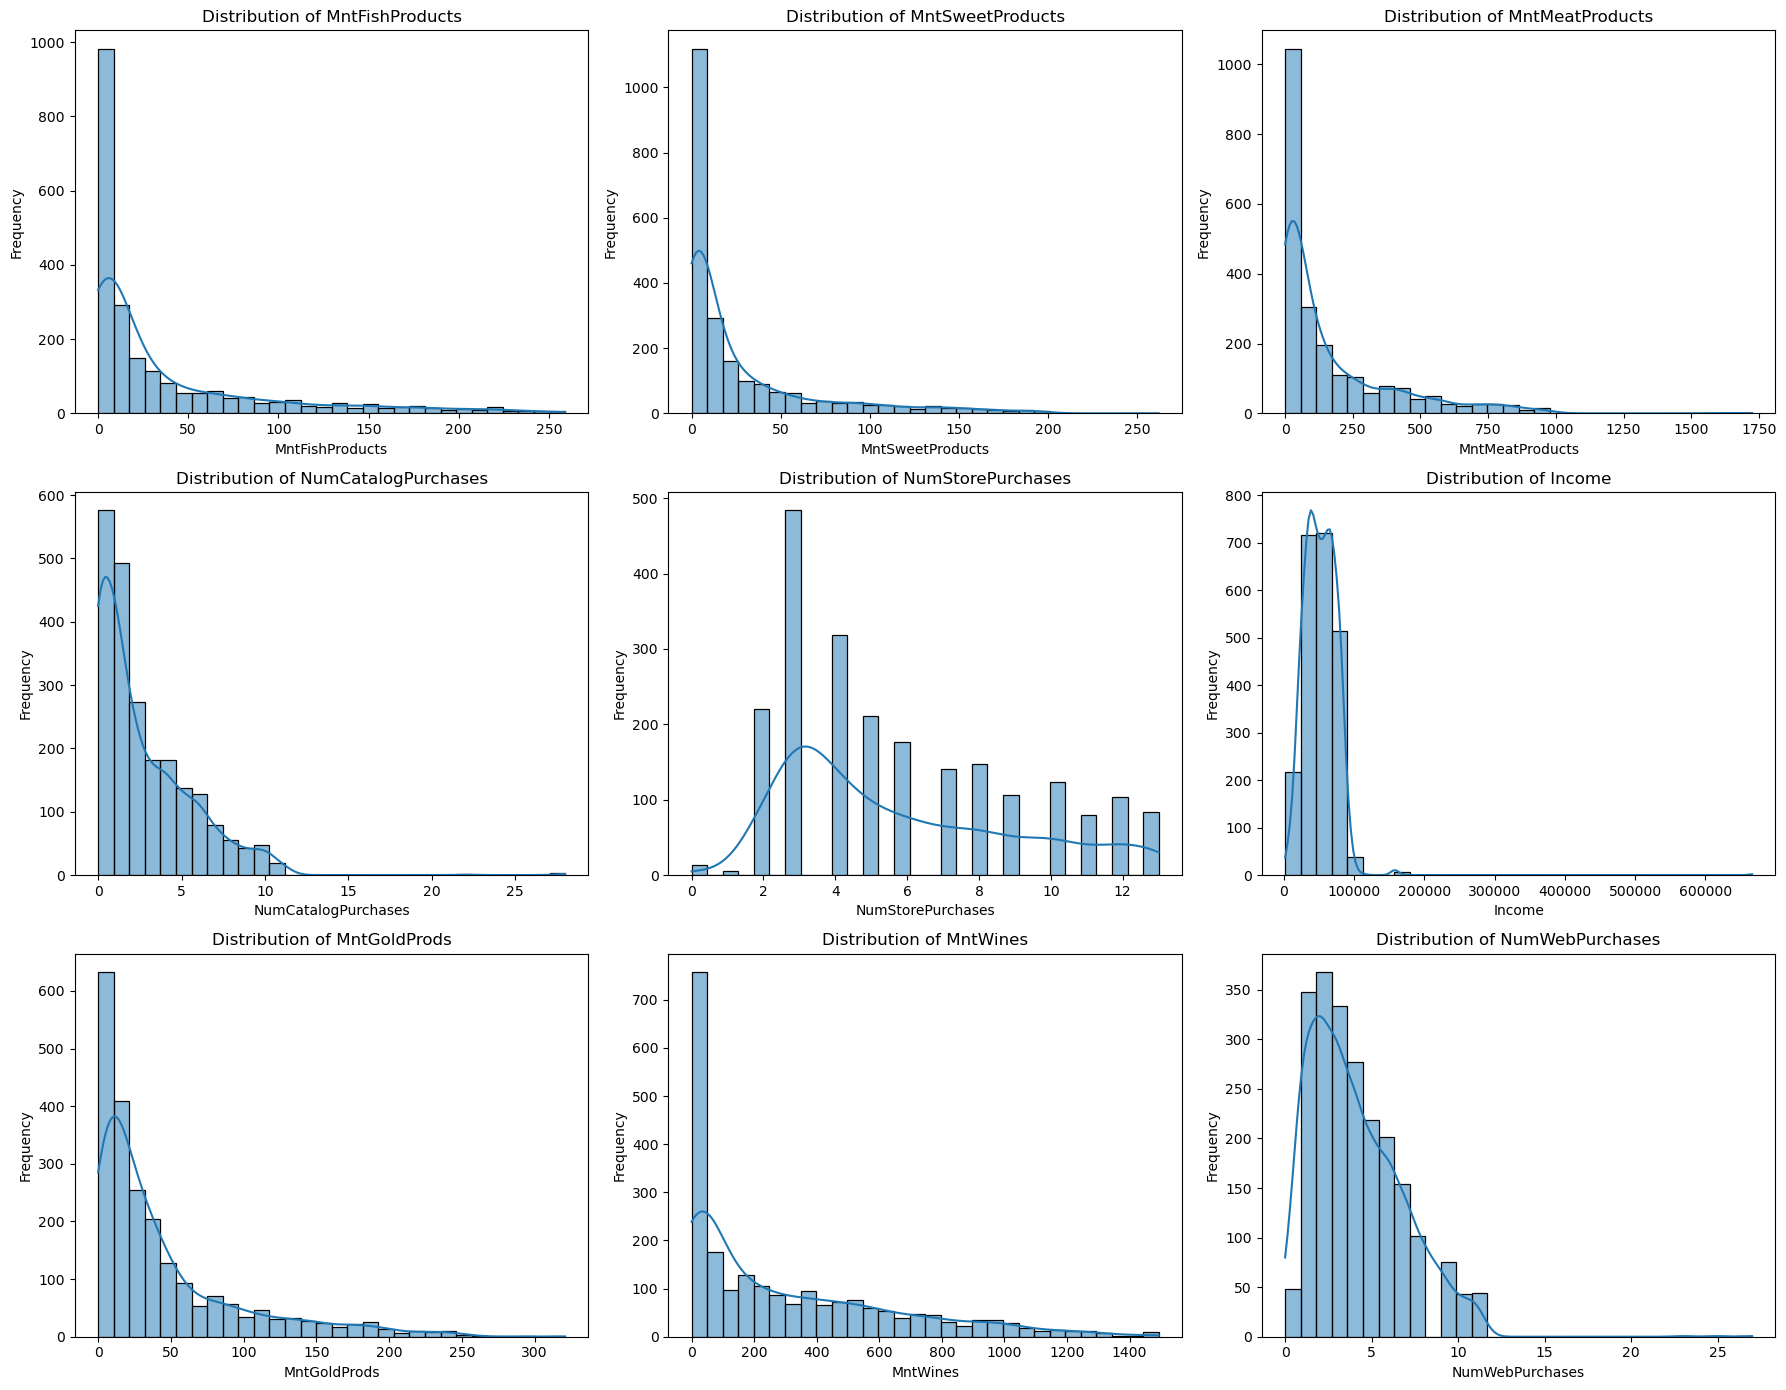

In [7]:
# Plot the selected features to show their distribution

numerical_features = [
    "MntFishProducts", "MntSweetProducts", "MntMeatProducts",
    "NumCatalogPurchases", "NumStorePurchases", "Income",
    "MntGoldProds", "MntWines", "NumWebPurchases"
]

# Create histogram for each feature
plt.figure(figsize=(18, 14))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
